In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\|
[Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| **Build Model** \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Build the Neural Network
========================

Neural networks comprise of layers/modules that perform operations on
data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) namespace
provides all the building blocks you need to build your own neural
network. Every module in PyTorch subclasses the
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
A neural network is a module itself that consists of other modules
(layers). This nested structure allows for building and managing complex
architectures easily.

In the following sections, we\'ll build a neural network to classify
images in the FashionMNIST dataset.


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Get Device for Training
=======================

We want to be able to train our model on an
[accelerator](https://pytorch.org/docs/stable/torch.html#accelerators)
such as CUDA, MPS, MTIA, or XPU. If the current accelerator is
available, we will use it. Otherwise, we use the CPU.


In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Define the Class
================

We define our neural network by subclassing `nn.Module`, and initialize
the neural network layers in `__init__`. Every `nn.Module` subclass
implements the operations on input data in the `forward` method.


In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork`, and move it to the `device`,
and print its structure.


In [5]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


To use the model, we pass it the input data. This executes the model\'s
`forward`, along with some [background
operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866).
Do not call `model.forward()` directly!

Calling the model on the input returns a 2-dimensional tensor with dim=0
corresponding to each output of 10 raw predicted values for each class,
and dim=1 corresponding to the individual values of each output. We get
the prediction probabilities by passing it through an instance of the
`nn.Softmax` module.


In [14]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3])


------------------------------------------------------------------------


Model Layers
============

Let\'s break down the layers in the FashionMNIST model. To illustrate
it, we will take a sample minibatch of 3 images of size 28x28 and see
what happens to it as we pass it through the network.


In [15]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


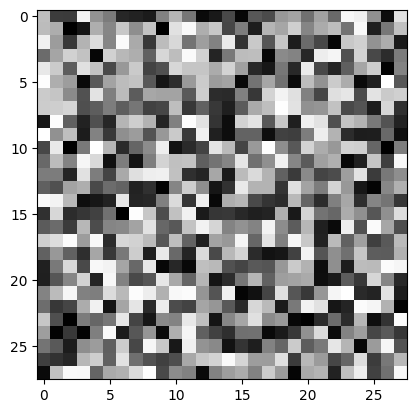

In [20]:
import matplotlib.pyplot as plt
plt.imshow(input_image[0].squeeze(), cmap='gray')
plt.show()

nn.Flatten
==========

We initialize the
[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)
layer to convert each 2D 28x28 image into a contiguous array of 784
pixel values ( the minibatch dimension (at dim=0) is maintained).


In [18]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


nn.Linear
=========

The [linear
layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using its
stored weights and biases.


In [21]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [22]:
print(hidden1[0])

tensor([ 0.4998,  0.0318, -0.1805,  0.2873,  0.2872, -0.0218,  0.7835, -0.5259,
         0.2253, -0.3048, -0.2233, -0.2448,  0.3509,  0.1704,  0.6442, -0.5538,
         0.4805, -0.2166,  0.2823, -0.1117], grad_fn=<SelectBackward0>)


nn.ReLU
=======

Non-linear activations are what create the complex mappings between the
model\'s inputs and outputs. They are applied after linear
transformations to introduce *nonlinearity*, helping neural networks
learn a wide variety of phenomena.

In this model, we use
[nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
between our linear layers, but there\'s other activations to introduce
non-linearity in your model.


In [23]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[ 0.4998,  0.0318, -0.1805,  0.2873,  0.2872, -0.0218,  0.7835, -0.5259,
          0.2253, -0.3048, -0.2233, -0.2448,  0.3509,  0.1704,  0.6442, -0.5538,
          0.4805, -0.2166,  0.2823, -0.1117],
        [ 0.6603,  0.2845,  0.0073,  0.2975,  0.5761, -0.3285,  0.3809, -0.2447,
         -0.0504, -0.2058,  0.1988, -0.5547,  0.5399,  0.0343,  0.5089, -0.6171,
          0.5507, -0.1994,  0.0756,  0.0155],
        [ 0.7240,  0.2789,  0.1367,  0.2872,  0.4828, -0.0461,  0.1455, -0.2366,
          0.0387, -0.3466, -0.2018,  0.0044,  0.4221,  0.1797,  0.3065, -0.5903,
          0.5246, -0.3333, -0.0428, -0.4042]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.4998, 0.0318, 0.0000, 0.2873, 0.2872, 0.0000, 0.7835, 0.0000, 0.2253,
         0.0000, 0.0000, 0.0000, 0.3509, 0.1704, 0.6442, 0.0000, 0.4805, 0.0000,
         0.2823, 0.0000],
        [0.6603, 0.2845, 0.0073, 0.2975, 0.5761, 0.0000, 0.3809, 0.0000, 0.0000,
         0.0000, 0.1988, 0.0000, 0.5399, 0.0343, 0.50

nn.Sequential
=============

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
is an ordered container of modules. The data is passed through all the
modules in the same order as defined. You can use sequential containers
to put together a quick network like `seq_modules`.


In [24]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

nn.Softmax
==========

The last linear layer of the neural network returns [logits]{.title-ref}
- raw values in \[-infty, infty\] - which are passed to the
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
module. The logits are scaled to values \[0, 1\] representing the
model\'s predicted probabilities for each class. `dim` parameter
indicates the dimension along which the values must sum to 1.


In [25]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [26]:
print(pred_probab)

tensor([[0.1184, 0.0671, 0.0972, 0.0793, 0.1062, 0.0974, 0.0870, 0.0940, 0.1089,
         0.1446],
        [0.1165, 0.0617, 0.0797, 0.0852, 0.1239, 0.1106, 0.0741, 0.1024, 0.0933,
         0.1525],
        [0.1087, 0.0668, 0.0816, 0.0928, 0.1122, 0.1182, 0.0846, 0.1049, 0.1006,
         0.1297]], grad_fn=<SoftmaxBackward0>)


Model Parameters
================

Many layers inside a neural network are *parameterized*, i.e. have
associated weights and biases that are optimized during training.
Subclassing `nn.Module` automatically tracks all fields defined inside
your model object, and makes all parameters accessible using your
model\'s `parameters()` or `named_parameters()` methods.

In this example, we iterate over each parameter, and print its size and
a preview of its values.


In [27]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0306,  0.0240,  0.0345,  ...,  0.0047,  0.0161, -0.0034],
        [-0.0222,  0.0349, -0.0329,  ..., -0.0131, -0.0162, -0.0045]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0336, -0.0257], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0428, -0.0086, -0.0283,  ...,  0.0290,  0.0059, -0.0219],
        [-0.0328, -0.0266, -0.0216,  ...,  0.0023,  0.0047, -0.0038]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

------------------------------------------------------------------------


Further Reading
===============

-   [torch.nn API](https://pytorch.org/docs/stable/nn.html)
